In [178]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import gmplot as gp
from PIL import Image

from xgboost import XGBClassifier
import xgboost
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.interpolate import LinearNDInterpolator

In [179]:
df = pd.read_csv('data_stephen_fix_header.csv', header=[0])
df = df.drop(df[df['latitude'] >= 69.4475].index)

In [201]:
df.tail()

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,organic_cover,top_of_interval,bottom_of_interval,month,year,interval_length
2832,68.38262,-133.71211,2013-04-27T00:00:00Z,W14103137-S6-BH15,5.45,1,Nf,NaN,NaN,Till,0.0,2.7,8.2,4,2013,5.5
2833,68.38262,-133.71211,2013-04-27T00:00:00Z,W14103137-S6-BH15,8.65,1,Nbn,NaN,NaN,Till,0.0,8.2,9.1,4,2013,0.9
2834,68.38386,-133.70967,2013-04-27T00:00:00Z,W14103137-S6-BH16,0.05,0,NaN,NaN,ORGANICS,Organics,0.1,0.0,0.1,4,2013,0.1
2835,68.38386,-133.70967,2013-04-27T00:00:00Z,W14103137-S6-BH16,0.35,0,NaN,NaN,NaN,Till,0.1,0.1,0.6,4,2013,0.5
2836,68.38386,-133.70967,2013-04-27T00:00:00Z,W14103137-S6-BH16,4.85,1,Nbn,NaN,NaN,Till,0.1,0.6,9.1,4,2013,8.5


In [180]:
# df.loc[df['cryostructures'].str.contains('Vx', na=False), 'cryostructures'] = 'Vx'
# df.loc[df['cryostructures'].str.contains('Nf', na=False), 'cryostructures'] = 'Nf'
# df.loc[df['cryostructures'].str.contains('Nbn', na=False), 'cryostructures'] = 'Nbn'
df['cryostructures'] = df['cryostructures'].str.split('/').str[0]
df['cryostructures'].replace(['Vx, Vs'], 'Vx', regex=True, inplace=True)
df['cryostructures'].replace(['Vx, Vc'], 'Vx', regex=True, inplace=True)

In [181]:
# merge materials (target) classes
# types of ice -> ice
# types of till -> till

df['materials'].replace(['ICE'], 'ice', regex=True, inplace=True)
df['materials'].replace(['ICE'], 'Ice', regex=True, inplace=True)
df['materials'].replace(['ice'], 'Ice', regex=True, inplace=True)
df['materials'].replace(['Pure Ice'], 'Ice', regex=True, inplace=True)

df['materials'].replace(['Coarse till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['Fine till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['Fine Till'], 'Till', regex=True, inplace=True)

# df['materials'].replace(['Till'], 'Sand', regex=True, inplace=True)
# df['materials'].replace(['Silt'], 'Sand', regex=True, inplace=True)

# df['materials'].replace(['Cobbles'], 'Gravel', regex=True, inplace=True)

df['visible_ice'].replace(['None'], 'No visible ice', regex=True, inplace=True)


# print(df.materials.value_counts().index)
# df.materials = df.materials.astype('category').cat.codes
# print(df.materials.value_counts().index)

# convert_to_code('materials')
# convert_to_code('cryostructures')
# convert_to_code('ASTM_2488')

ordered_ice = ['No visible ice', 'Low', "Medium to high", 'High', 'Pure ice']
df['visible_ice'] = pd.Series(pd.Categorical(df['visible_ice'], categories=ordered_ice, ordered=True))
# convert_to_code('visible_ice')


# convert timecodes to year and month columns
datetimes = pd.to_datetime(df['time'])
df['month'] = datetimes.dt.month
df['year'] = datetimes.dt.year

In [182]:
df['interval_length'] = df['bottom_of_interval'] - df['top_of_interval']

In [183]:
def convert_to_code(df, column):
    print(df[column].value_counts().index)
    df[column] = df[column].astype('category').cat.codes
    print(df[column].value_counts().index)

## Plot visible ice mean over depth

In [109]:
# df = df.dropna(subset=['visible_ice'])
# convert_to_code(df, 'visible_ice')

In [133]:
visible_ice_mean = df.groupby(['borehole'])['visible_ice'].mean().values

In [118]:
df_unique = df.drop_duplicates(subset='borehole')

In [134]:
df_unique['visible_ice_mean'] = visible_ice_mean


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


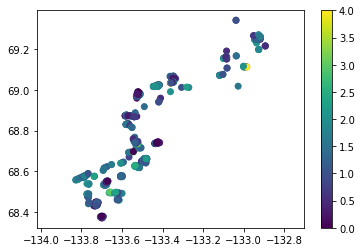

In [136]:
plt.scatter(df_unique.longitude, df_unique.latitude, c = visible_ice_mean)
plt.axis('equal')
plt.colorbar()

## xgboost stuff

In [184]:
print(df.latitude.max())
print(df.latitude.min())
print(df.longitude.max())
print(df.longitude.min())

69.34394
68.36933
-132.89346
-133.82843


In [185]:
feature_names = ['latitude', 'longitude', 'year', 'month', 'depth', 'interval_length'] #, 'organic_cover']

In [186]:
def xgboost_shap(label_name):
    df_temp = df.dropna(subset=[label_name])
    convert_to_code(df_temp, label_name)
    data = np.array(df_temp.filter(feature_names))
    labels = df_temp[label_name]

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2) #, random_state=0

    classifier = XGBClassifier()
    classifier.fit(X_train, y_train) 

    y_pred = classifier.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))

    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(data)

    shap.summary_plot(shap_values, plot_type="bar", feature_names=feature_names, show=False)
    plt.title(label_name)
    plt.show()

In [187]:
def xgboost_shap_layers(label_name, depth_top, depth_bottom=1000):
    df_temp = df.dropna(subset=[label_name])
    
    df_temp = df_temp.loc[(df_temp['depth'] >= depth_top) & (df_temp['depth'] <= depth_bottom)]
    
    convert_to_code(df_temp, label_name)
    data = np.array(df_temp.filter(feature_names))
    labels = df_temp[label_name]

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3) #, random_state=0

    classifier = XGBClassifier()
    classifier.fit(X_train, y_train) 

    y_pred = classifier.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))

    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(data)

    shap.summary_plot(shap_values, plot_type="bar", feature_names=feature_names, show=False)
    plt.title(label_name)
    plt.show()

In [188]:
def xgboost_shap_train_all_layers(label_name, depth_top, depth_bottom=1000):
    df_temp = df.dropna(subset=[label_name])
    
    convert_to_code(df_temp, label_name)
    data = np.array(df_temp.filter(feature_names))
    labels = df_temp[label_name]

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3) #, random_state=0
    
    print((X_test['depth'] >= depth_top) & (X_test['depth'] <= depth_bottom))
#     X_test = X_test.loc[(X_test['depth'] >= depth_top) & (X_test['depth'] <= depth_bottom)]
#     Y_test = Y_test.loc[(X_test['depth'] >= depth_top) & (X_test['depth'] <= depth_bottom)]

    classifier = XGBClassifier()
    classifier.fit(X_train, y_train) 

    y_pred = classifier.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))

    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(data)

    shap.summary_plot(shap_values, plot_type="bar", feature_names=feature_names, show=False)
    plt.title(label_name)
    plt.show()

## visualize layers

In [189]:
label_name = 'frozen'
df_temp = df.dropna(subset=[label_name])
convert_to_code(df_temp, label_name)
data = np.array(df_temp.filter(feature_names))
labels = df_temp[label_name]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2) #, random_state=0

classifier = XGBClassifier()
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

Int64Index([1, 0], dtype='int64')
Int64Index([1, 0], dtype='int64')
[14:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 52  13]
 [ 11 488]]
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        65
           1       0.97      0.98      0.98       499

    accuracy                           0.96       564
   macro avg       0.90      0.89      0.89       564
weighted avg       0.96      0.96      0.96       564

0.9574468085106383


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [190]:
feature_names

['latitude', 'longitude', 'year', 'month', 'depth', 'interval_length']

In [191]:
latitude_max = 69.5
latitude_min = 68.3
longitude_max = -132.8
longitude_min = -133.9
# latitude_max = df.latitude.max()
# latitude_min = df.latitude.min()
# longitude_max = df.longitude.max()
# longitude_min = df.longitude.min()

n_lat = 80
n_lng = 40

lng_range = np.linspace(longitude_min, longitude_max, n_lng)
lat_range = np.linspace(latitude_min, latitude_max, n_lat)
depth_range = [1, 3, 5, 7, 9]
grid_lng, grid_lat, grid_depth = np.meshgrid(lng_range, lat_range, depth_range)
X_syn = np.zeros([len(grid_lng.flatten()), len(feature_names)])


In [192]:
X_syn.shape

(16000, 6)

In [193]:
X_syn[:, 0] = grid_lat.flatten() # latitude
X_syn[:, 1] = grid_lng.flatten() # longitude
X_syn[:, 2] = 2013 # year
X_syn[:, 3] = 3 # month
X_syn[:, 4] = grid_depth.flatten() # depth
X_syn[:, 5] = 2 # interval length

In [194]:
Y_syn = classifier.predict(X_syn)

In [195]:
Y_syn_reshaped = Y_syn.reshape(n_lng, n_lat, len(depth_range))

In [196]:
Y_syn_reshaped.shape

(40, 80, 5)

In [197]:
Y_syn_sum = np.sum(Y_syn_reshaped, axis=-1)

## plot layers on map

In [198]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import to_hex

Text(0.5, 1.0, 'Sum of depth layers')

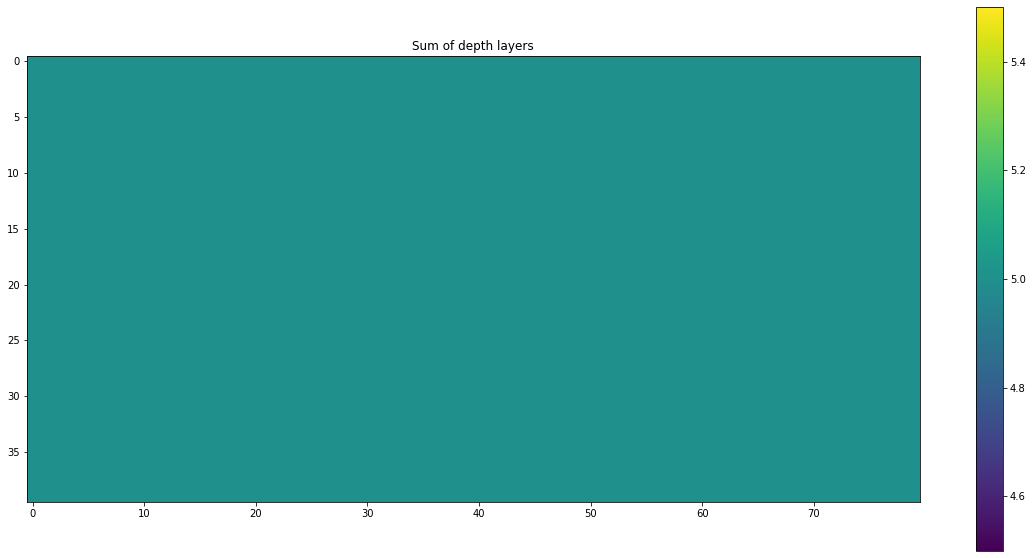

In [199]:
plt.imshow(Y_syn_sum)
plt.rcParams['figure.figsize'] = [5,5]
plt.colorbar()
plt.title("Sum of depth layers")

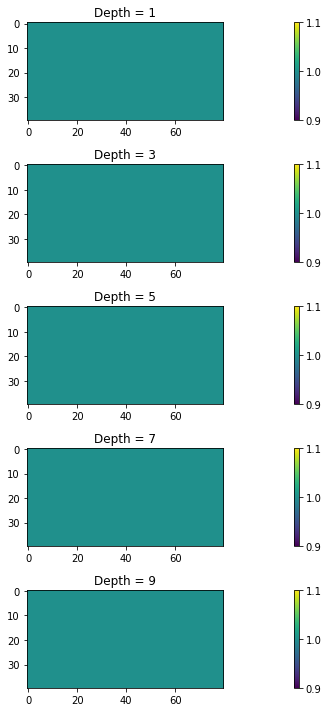

In [200]:
plt.rcParams['figure.figsize'] = [20, 10]
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.imshow(Y_syn_reshaped[:,:,i])
    plt.colorbar()
    plt.title('Depth = {}'.format(depth_range[i]))

plt.tight_layout()
plt.savefig('xgboost_predicted_depth_layers.png')

In [112]:
import gmplot as gp

mean_lat = df.latitude.unique().mean()
mean_lng = df.longitude.unique().mean()

grid_lng_2d, grid_lat_2d = np.meshgrid(lng_range, lat_range)
grid_lng_2d = grid_lng_2d.flatten()
grid_lat_2d = grid_lat_2d.flatten()

grid_lat_2d.shape

(800,)

In [121]:
predicted_2d = Y_syn_reshaped[:, :, 0]
predicted_2d = predicted_2d.flatten()
ocean = cm.get_cmap('inferno',predicted_2d.max())
color_ice = ocean(predicted_2d)
len(color_ice)

800

In [122]:
color_ice_hex = [None] * len(color_ice)

In [123]:
color_ice[0]

array([1.4620e-03, 4.6600e-04, 1.3866e-02, 1.0000e+00])

In [124]:
for i, color in enumerate(color_ice):
    color_ice_hex[i] = to_hex(color)

## xgboost train on all layers, test on single layer

In [76]:
current_label_name = 'visible_ice'

In [72]:
xgboost_shap_train_all_layers(current_label_name, 0, 2.5)

CategoricalIndex(['No visible ice', 'Low', 'Medium to high', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([0, 2, 1, 4, 3], dtype='int64')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

## xgboot with depth layers

CategoricalIndex(['No visible ice', 'Medium to high', 'Low', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([0, 2, 1, 4, 3], dtype='int64')
[13:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[116  19  18   0   2]
 [ 24  21  17   0   0]
 [ 25  16  56   1   3]
 [  1   3   3   0   0]
 [  4   6  10   0   0]]
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       155
           1       0.32      0.34      0.33        62
           2       0.54      0.55      0.55       101
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        20

    accuracy                           0.56       345
   macro avg       0.31      0.33      0.32       345
weighted avg       0.52      0.56      0.54       345

0.5594202898550724


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


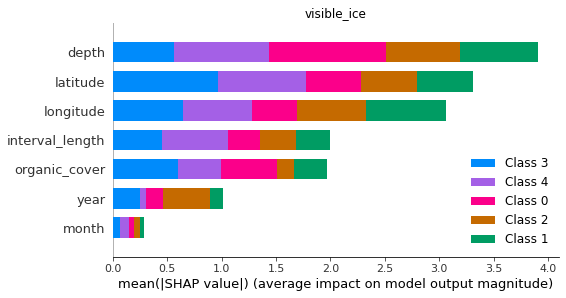

In [64]:
xgboost_shap_layers(current_label_name, 0, 2.5)

CategoricalIndex(['Low', 'No visible ice', 'Medium to high', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([1, 0, 2, 4, 3], dtype='int64')
[13:45:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[24 20  7  1  9]
 [13 23 17  2  5]
 [11 17 15  1  8]
 [ 0  2  2  0  2]
 [ 7  7 11  0  9]]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



              precision    recall  f1-score   support

           0       0.44      0.39      0.41        61
           1       0.33      0.38      0.36        60
           2       0.29      0.29      0.29        52
           3       0.00      0.00      0.00         6
           4       0.27      0.26      0.27        34

    accuracy                           0.33       213
   macro avg       0.27      0.27      0.27       213
weighted avg       0.33      0.33      0.33       213

0.3333333333333333


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


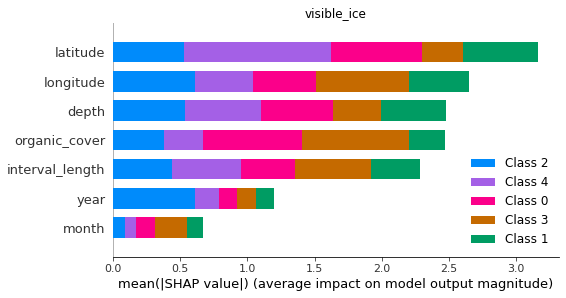

In [54]:
xgboost_shap_layers(current_label_name, 2.5, 5)

CategoricalIndex(['No visible ice', 'Low', 'Medium to high', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([0, 1, 2, 4, 3], dtype='int64')
[13:45:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[25 14  6  1  1]
 [11 12  7  1  2]
 [ 9  9 13  0  5]
 [ 1  1  3  0  0]
 [ 3  2  6  0  2]]
              precision    recall  f1-score   support

           0       0.51      0.53      0.52        47
           1       0.32      0.36      0.34        33
           2       0.37      0.36      0.37        36
           3       0.00      0.00      0.00         5
           4       0.20      0.15      0.17        13

    

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


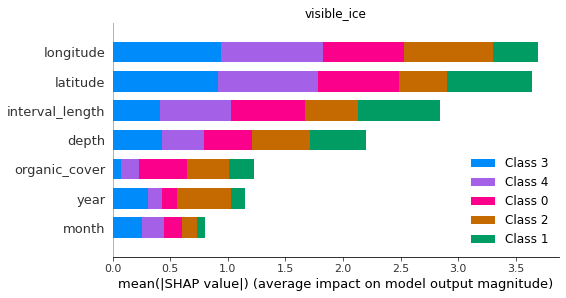

In [55]:
xgboost_shap_layers(current_label_name, 5, 7.5)

CategoricalIndex(['No visible ice', 'Low', 'Medium to high', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([0, 1, 2, 4, 3], dtype='int64')
[13:46:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[15  7  5  0  2]
 [ 6 12  5  1  2]
 [ 6  3  7  0  4]
 [ 0  0  0  0  0]
 [ 1  2  2  0  1]]
              precision    recall  f1-score   support

           0       0.54      0.52      0.53        29
           1       0.50      0.46      0.48        26
           2       0.37      0.35      0.36        20
           3       0.00      0.00      0.00         0
           4       0.11      0.17      0.13         6

    

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


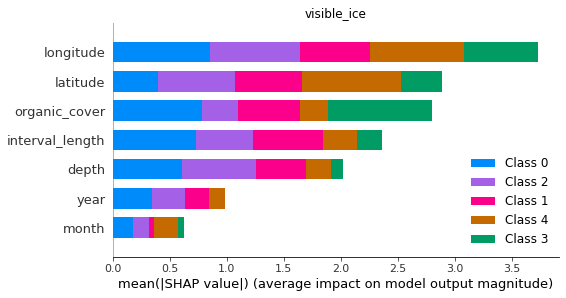

In [58]:
xgboost_shap_layers(current_label_name, 7.5, 10)

CategoricalIndex(['Low', 'Medium to high', 'No visible ice', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([1, 2, 0, 4, 3], dtype='int64')
[13:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1 3 2 0 0]
 [7 9 4 0 2]
 [3 5 7 0 1]
 [1 0 0 0 0]
 [0 0 1 1 3]]
              precision    recall  f1-score   support

           0       0.08      0.17      0.11         6
           1       0.53      0.41      0.46        22
           2       0.50      0.44      0.47        16
           3       0.00      0.00      0.00         1
           4       0.50      0.60      0.55         5

    accuracy                 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


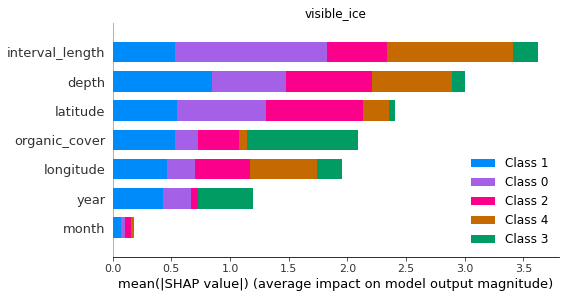

In [59]:
xgboost_shap_layers(current_label_name, 10)

## xgboost without depth layers

CategoricalIndex(['No visible ice', 'Low', 'Medium to high', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([0, 2, 1, 4, 3], dtype='int64')
[13:58:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[122  24  27   0   4]
 [ 35  60  36   2  10]
 [ 25  35  78   2  11]
 [  3   9   2   2   2]
 [ 14   8  17   0  16]]
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       177
           1       0.44      0.42      0.43       143
           2       0.49      0.52      0.50       151
           3       0.33      0.11      0.17        18
           4       0.37      0.29      0.33        55

    accuracy                           0.51       544
   macro avg       0.45      0.41      0.41       544
weighted avg       0.50      0.51      0.50       544

0.5110294117647058


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


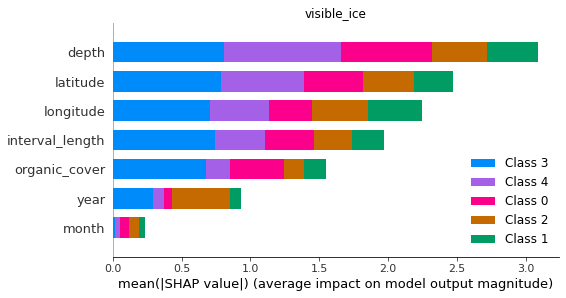

In [74]:
xgboost_shap('visible_ice')

In [75]:
y_pred = classifier.predict(X_test)

NameError: name 'classifier' is not defined

Index(['Clay', 'Sand', 'Till', 'Organics', 'Silt', 'Ice', 'Gravel', 'Rock',
       'Cobbles'],
      dtype='object')
Int64Index([0, 6, 8, 4, 7, 3, 2, 5, 1], dtype='int64')
[23:02:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[75  1  8  2  0 11  9  6]
 [ 1 12  4  0  0  5  5 18]
 [ 9  3  6  3  0  7  6  9]
 [ 0  0  0 86  0  3  3  2]
 [ 0  0  0  0  2  0  0  0]
 [17  7  5  2  0 46  7 18]
 [14  0  3  3  0 13 28  6]
 [ 6 11  4  0  1 16  7 54]]
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       112
           2       0.35      0.27      0.30        45
           3       0.20      0.14      0.16        43
           4       0.90      0.91      0.91        94
           5       0.67      1.00      0.80         2
           6       0.46      0.45      0.45       102
           7       0.43      0.42      0.42        67
           8       0.48      0.55      0.51        99

    accuracy                           0.55       564
   macro avg       0.51      0.55      0.53       564
weighted avg       0.53      0.55      0.54       564

0.5478723404255319


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


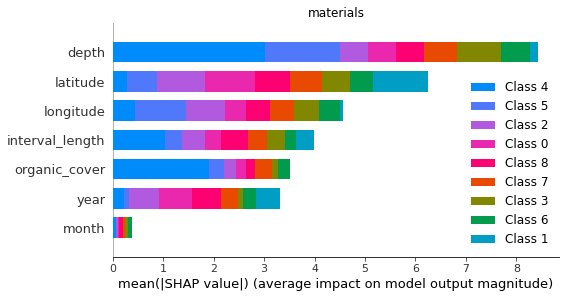

In [137]:
xgboost_shap('materials')

Index(['Vx', 'Nf', 'Nbn', 'Nbe', 'Vs', 'Vr', 'Vc'], dtype='object')
Int64Index([6, 2, 1, 0, 5, 4, 3], dtype='int64')
[23:02:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[ 6  5  3  0  0  3 15]
 [ 2 15 11  0  2  1 41]
 [ 5 14 51  0  0  0 18]
 [ 0  1  1  1  0  0  6]
 [ 1  0  0  1  1  1  9]
 [ 0  2  0  0  1  1 11]
 [ 3 19 17  0  2  0 89]]
              precision    recall  f1-score   support

           0       0.35      0.19      0.24        32
           1       0.27      0.21      0.23        72
           2       0.61      0.58      0.60        88
           3       0.50      0.11      0.18         9
           4       0.17      0.08      0.11        13
           5       0.17      0.07      0.10        15
           6       0.47      0.68      0.56       130

    accuracy                           0.46       359
   macro avg       0.36      0.27      0.29       359
weighted avg       0.43      0.46      0.43       359

0.4568245125348189


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


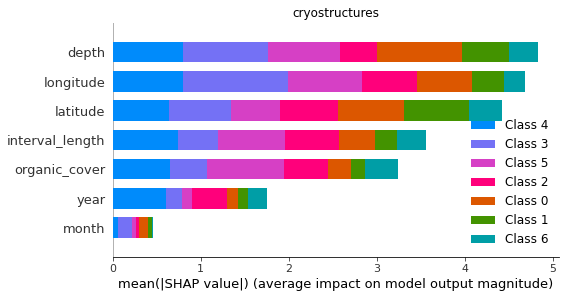

In [138]:
xgboost_shap('cryostructures')

Int64Index([1, 0], dtype='int64')
Int64Index([1, 0], dtype='int64')
[14:12:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 54  16]
 [  3 491]]
              precision    recall  f1-score   support

           0       0.95      0.77      0.85        70
           1       0.97      0.99      0.98       494

    accuracy                           0.97       564
   macro avg       0.96      0.88      0.92       564
weighted avg       0.97      0.97      0.96       564

0.9663120567375887


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


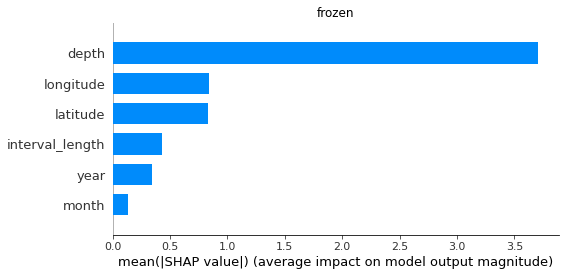

In [202]:
xgboost_shap('frozen')

Index(['CL', 'ICE', 'PEAT', 'ORGANICS', 'ML', 'SM', 'SP', 'SC', 'TOPSOIL',
       'CL-ML', 'GP-GM', 'SC-SM', 'SP-SM', 'TILL', 'GP', 'CH', 'GW', 'GW-GM',
       'SM-SC', 'SW', 'GM', 'SW-SM', 'GC', 'GP-GC', 'GM-GC', 'MH', 'SP-SC',
       'SW-SC', 'GC-GM', 'SP-SW', 'GW-GC', 'ROCK', 'COBBLES', 'SW-SP', 'ML-CL',
       'SP-GP', 'ML-SM', 'SW-GC'],
      dtype='object')
Int64Index([ 1, 14, 20, 16, 19, 24, 26, 22, 37,  2, 10, 23, 29, 36,  8,  0, 11,
            25, 13, 31,  6, 34,  4, 15,  9,  7, 28, 33,  5, 30, 12, 17, 21,  3,
            35, 32, 27, 18],
           dtype='int64')
[23:02:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[ 4  2  0 ...  0  0  0]
 [ 2 33  0 ...  0  2  0]
 [ 0  3 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  0 ...  0  0 14]]
              precision    recall  f1-score   support

           0       0.67      0.25      0.36        16
           1       0.50      0.54      0.52        61
           2       0.68      0.50      0.58        26
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3
           8       0.50      0.45      0.48        11
           9       0.00      0.00      0.00         3
          10       0.25      0.15      0.19        13
          11       0.17      0.14      0.15         7
          12       0.00      0.00      0.00         1
          13       1.00      0.10      0.18        10
          14       0.35      0.35      0.35        51
          15       0.00      0.00

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


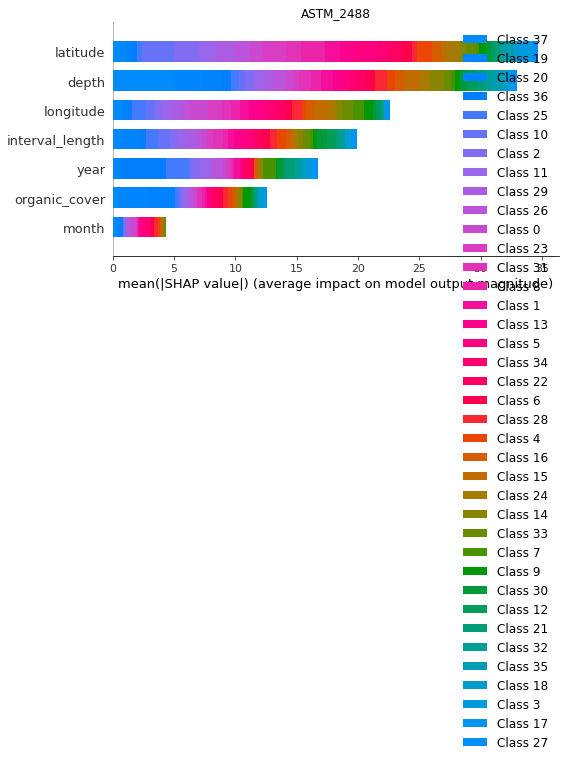

In [140]:
xgboost_shap('ASTM_2488')